In [92]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Regions

In [8]:
regionsDF = pd.read_csv("../originalDataset/noc_regions.csv")

In [9]:
regionsDF.head()

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [10]:
len(regionsDF)

230

Existem 230 entradas

In [11]:
regionsDF.isna().sum()

NOC         0
region      3
notes     209
dtype: int64

A maioria das anotações são nulas

In [12]:
regionsDF[regionsDF['region'].isna()]

,NOC,region,notes
168,ROT,NaN,Refugee Olympic Team
208,TUV,NaN,Tuvalu
213,UNK,NaN,Unknown


Existem três regiões que não possuem nome. Uma é o UNKNOWN, Comitê Olímpico de Refugiados e Tuvalu. Podemos alterar todos os seus valores posteriormente.

In [13]:
regionsDF[~regionsDF['notes'].isna()]

,NOC,region,notes
1,AHO,Curacao,Netherlands Antilles
6,ANT,Antigua,Antigua and Barbuda
7,ANZ,Australia,Australasia
26,BOH,Czech Republic,Bohemia
51,CRT,Greece,Crete
88,HKG,China,Hong Kong
93,IOA,Individual Olympic Athletes,Individual Olympic Athletes
99,ISV,"Virgin Islands, US",Virgin Islands
143,NBO,Malaysia,North Borneo
147,NFL,Canada,Newfoundland


Pode-se ver que alguns NOC's representam regiões específicas de países maiores como Australasia na Australia, Bohemia na atual Chéquia, Creta na Grécia e NewFoundland no Canadá. Talvez a gente possa resolver isso ou deixar quieto.

# Athletes

In [14]:
athletesDf = pd.read_csv("../originalDataset/athlete_events.csv")

In [15]:
athletesDf.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [16]:
len(athletesDf)

271116

In [17]:
athletesDf.isna().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

Podemos perceber algumas coisas de acordo com a quantidade de dados faltando:
- A maioria dos atletas não receberam medalhas e, por isso, a grande maioria deles não possui uma entrada na coluna Medal
- Cerca de 1/5 das entradas estão sem dados sobre altura e peso
- Uma pequena parcela menor está sem idade

Para toda entrada com dado de peso e altura faltando, já que um mesmo atleta pode aparecer mais de uma vez (ver o ID do atleta na linha), podemos agrupar os dados por atleta e verificar se, em alguma de suas entradas, possui a informação que está faltando na outra entrada. A partir disso, podemos tentar completar seus dados. 

O mesmo pode ser feito para a idade do atleta apenas verificando em qual jogos ele participou e calcular a idade dele para os outros eventos.

## Tentando completar os dados

In [18]:
athletesByID = athletesDf.groupby('ID')

In [33]:
athletesByID.size().sort_values(ascending=False)[:5]

ID
77710     58
106296    39
115354    38
119591    36
44875     32
dtype: int64

In [72]:
athletesByID.ngroups #total num of groups. Egual to total num of athletes

135571

In [73]:
def countNullStats(groupByDf, col):
    """
    col: The col to check for null's/na's
    """
    noCol = set() #have a null value for that col in any row of group
    colFound = set() #does not have any null value for that col in any row of group
    noColButFound = set() #have a null value in some row but other row has a value
    
    for groupId, (groupedId, data) in enumerate(groupByDf):
        nas = data[col].isna() 
        if nas.sum() > 0:
            noCol.add(groupId)
            if len(data[~nas]) > 0:
                noColButFound.add(groupId)
        else:
            colFound.add(groupId)
    
    return noCol, colFound, noColButFound

In [56]:
noHeight, heightFound, noHeightButFound = countNullStats(athletesByID, 'Height')

In [58]:
print(f"allHeightsFound: {len(heightFound)}, hasNullHeight: {len(noHeight)}, hasNullButFoundToo: {len(noHeightButFound)} ")

allHeightsFound: 101655, hasNullHeight: 33916, hasNullButFoundToo: 0 


In [64]:
noWeight, weightFound, noweightButFound = countNullStats(athletesByID, 'Weight')

In [65]:
print(f"allWeightsFound: {len(weightFound)}, hasNullWeight: {len(noWeight)}, hasNullButFoundToo: {len(noweightButFound)} ")

allWeightsFound: 100686, hasNullWeight: 34885, hasNullButFoundToo: 0 


In [66]:
noAge, AgeFound, noAgeButFound = countNullStats(athletesByID, 'Age')

In [67]:
print(f"allAgesFound: {len(AgeFound)}, hasNullAge: {len(noAge)}, hasNullButFoundToo: {len(noAgeButFound)} ")

allAgesFound: 129203, hasNullAge: 6368, hasNullButFoundToo: 0 


De acordo com os resultados, cerca de 1/4 dos atletas realmente não possuem dados de peso ou altura. Além disso, cerca de 6300 atletas não possuem dados de idade. Assim sendo, a ideia original para completar os dados não poderá ser feita.

Uma opção é se desfazer de todas as entradas que possuem NaN values.

### Dados faltantes por ano de competição

In [74]:
athletesByYearAndID = athletesDf.groupby(["Year", "ID"])

In [84]:
noHeightPerYear = {year:0 for year in athletesDf['Year'].unique()} #num athletes with no height per year
noAgePerYear = noHeightPerYear.copy() #num athletes with no age per year
noWeightPerYear = noHeightPerYear.copy() #num athletes with no weight per year
for (year, athleteId), data in athletesByYearAndID:
    if data['Height'].isna().sum() > 0:
        noHeightPerYear[year] +=1

    if data['Weight'].isna().sum() > 0:
        noWeightPerYear[year] +=1
    
    if data['Age'].isna().sum() > 0:
        noAgePerYear[year] +=1


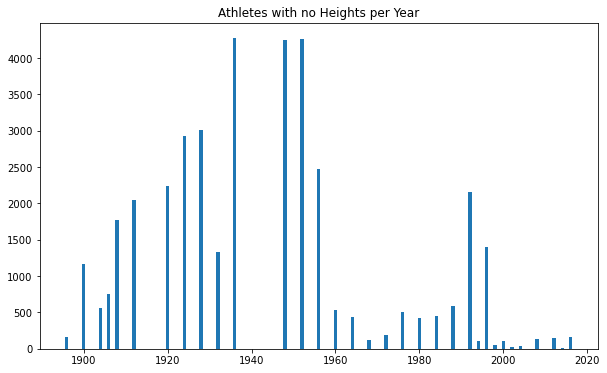

In [99]:
plt.figure(figsize=(10,6))
plt.bar(*zip(*noHeightPerYear.items()))
plt.title("Athletes with no Heights per Year")
plt.show()

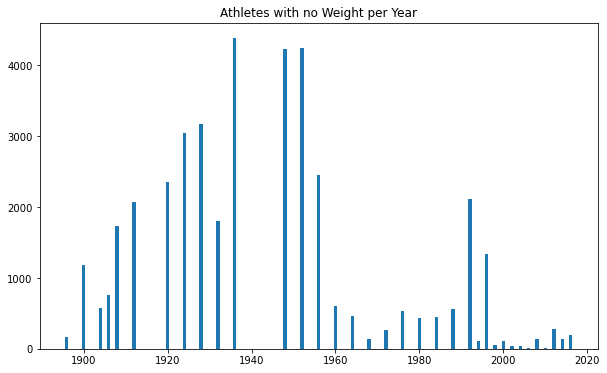

In [100]:
plt.figure(figsize=(10,6))
plt.bar(*zip(*noWeightPerYear.items()))
plt.title("Athletes with no Weight per Year")
plt.show()

O gráfico de no Weight e no Height são muito semelhantes e, talvez, iguais

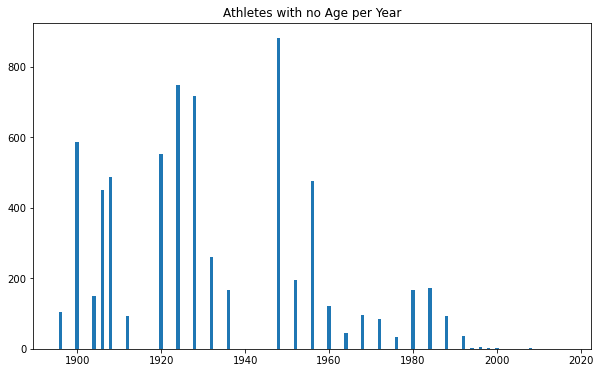

In [101]:
plt.figure(figsize=(10,6))
plt.bar(*zip(*noAgePerYear.items()))
plt.title("Athletes with no Age per Year")
plt.show()

Pode-se perceber que, de 1996-2000 para cá, os dados estão mais completos